In [27]:
import sys
sys.path.append('../../')
sys.path.append('../../lib/src/')

import torch
from torch import nn
from itertools import islice
import os
import numpy as np
from matplotlib import pyplot as plt


from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_ColorMNIST, Decoder_ColorMNIST,Encoder_Chairs, Decoder_Chairs, My_MaskedDataset
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback


from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling


from riemannian_random_walk.models.generation import hmc_manifold_sampling, random_walk_batch


def plot_sequence(grid, color=False):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def extract_dataset(loader, c = 3, h = 28, w = 28):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        data = data.reshape(-1, c, h, w)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset
    

%reload_ext autoreload
%autoreload 2
!nvidia-smi

Thu Aug  1 16:10:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   36C    P8             10W /   70W |     119MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([7000, 1, 64, 64])


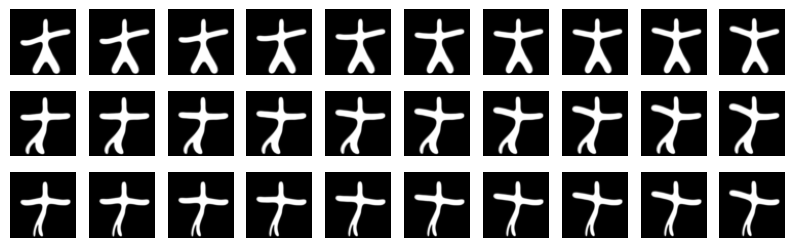

In [42]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
DATA_PATH = 'data-models/starmen/data/starmen_data.pt' #modify if needed
train_data = torch.load(DATA_PATH)[:700].unsqueeze(2).reshape(-1, 1, 64, 64)
eval_data = torch.load(DATA_PATH)[700:900].unsqueeze(2).reshape(-1, 1, 64, 64)
test_data = torch.load(DATA_PATH)[900:].unsqueeze(2).reshape(-1, 1, 64, 64)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

plot_sequence(train_data[:30].reshape(3, 10, 1, 64, 64), color=False)

In [62]:
input_dim = (1, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3

##############


latent_dim = new_num_channels* (input_dim[1] // f) * (input_dim[2] // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=200,
learning_rate=1e-3,
per_device_train_batch_size=256,
per_device_eval_batch_size=256,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


model_config = VAEConfig(input_dim=input_dim, 
                         latent_dim= latent_dim, uses_default_encoder= False, 
                         uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cpu'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder, beta = 0.1).to(device)
print('Number of trainable parameters:', sum(p.numel() for p in vae.parameters() if p.requires_grad))


Latent dim: 12
Number of trainable parameters: 1074281


In [ ]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name=f"starmen_pretraining-VAE_latdim{latent_dim}", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    callbacks=callbacks
)

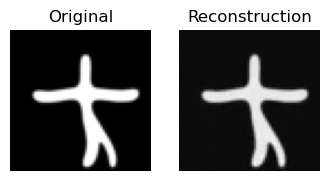

MSE  tensor(0.8956, grad_fn=<MeanBackward1>)


In [66]:
idx = 134
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0), cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0), cmap='gray')
plt.title('Reconstruction')
plt.axis('off')
plt.show()
print('MSE ', ((out.recon_x - x.data)**2).sum(dim = (1,2)).mean(dim = 0))